# Model Comparison with torch.compile: MinGRU vs Mamba vs Transformer

이 노트북에서는 **torch.compile**을 적용한 4가지 시퀀스 모델의 학습 및 추론 성능을 비교합니다.

## 비교 모델

1. **MinGRU (Triton) + compile**: Triton 커널 + torch.compile
2. **MinGRU (CUDA) + compile**: CUDA C++ 커널 + torch.compile
3. **Mamba + compile**: State Space Model + torch.compile
4. **Transformer (LLaMA) + compile**: Flash Attention + torch.compile

## torch.compile 옵션

- `mode="reduce-overhead"`: 커널 실행 오버헤드 감소
- `fullgraph=True`: 전체 그래프 컴파일 (가능한 경우)

## 참고

- torch.compile은 PyTorch 2.0+에서 지원
- 첫 번째 배치에서 컴파일 시간이 소요됨 (warmup)
- 이후 배치부터 최적화된 성능 발휘

In [1]:
import sys
import os
import math
import time
from dataclasses import dataclass
from typing import Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

# torch.compile 지원 확인
print(f"\ntorch.compile available: {hasattr(torch, 'compile')}")

PyTorch Version: 2.8.0+cu128
CUDA Available: True
GPU: NVIDIA A100 80GB PCIe
CUDA Version: 12.8

torch.compile available: True


## Hyperparameters and Configuration

In [2]:
# Model Configuration (유사한 파라미터 수를 위한 설정)
SEQUENCE_LENGTH = 256
EMBEDDING_DIM = 64
HIDDEN_DIM = 128
NUM_LAYERS = 4
NUM_HEADS = 4
FFN_DIM = 256
DROPOUT = 0.1

# Mamba specific
STATE_SIZE = 16
D_CONV = 4
EXPAND = 2

# Training Configuration
BATCH_SIZE = 512
EPOCHS = 20
LEARNING_RATE = 1e-3
VALIDATION_SPLIT = 0.1

# torch.compile Configuration
COMPILE_MODE = "reduce-overhead"  # Options: "default", "reduce-overhead", "max-autotune"
WARMUP_BATCHES = 5  # Number of warmup batches for compiled models

# Results Directory
RESULTS_DIR = 'results/11_model_comparison_compiled'
os.makedirs(RESULTS_DIR, exist_ok=True)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Compile mode: {COMPILE_MODE}")
print(f"Results will be saved to: {RESULTS_DIR}")

# Reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda
Compile mode: reduce-overhead
Results will be saved to: results/11_model_comparison_compiled


## Data Preparation

TinyShakespeare 데이터셋을 사용한 문자 수준 언어 모델링

In [3]:
def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return f.read()

def create_char_mappings(text):
    chars = sorted(list(set(text)))
    char_to_idx = {ch: i for i, ch in enumerate(chars)}
    idx_to_char = {i: ch for i, ch in enumerate(chars)}
    return chars, char_to_idx, idx_to_char

class CharDataset(Dataset):
    def __init__(self, text, seq_length, char_to_idx):
        self.text = text
        self.seq_length = seq_length
        self.char_to_idx = char_to_idx

    def __len__(self):
        return len(self.text) - self.seq_length

    def __getitem__(self, idx):
        x = [self.char_to_idx[ch] for ch in self.text[idx:idx+self.seq_length]]
        y = [self.char_to_idx[ch] for ch in self.text[idx+1:idx+self.seq_length+1]]
        return torch.tensor(x), torch.tensor(y)

def prepare_data(text, seq_length, batch_size, val_split):
    chars, char_to_idx, idx_to_char = create_char_mappings(text)
    
    val_size = int(len(text) * val_split)
    train_text, val_text = text[:-val_size], text[-val_size:]
    
    train_dataset = CharDataset(train_text, seq_length, char_to_idx)
    val_dataset = CharDataset(val_text, seq_length, char_to_idx)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    return train_loader, val_loader, chars, char_to_idx, idx_to_char

In [4]:
# Load data
text = load_data('../data/input.txt')
train_loader, val_loader, chars, char_to_idx, idx_to_char = prepare_data(
    text, SEQUENCE_LENGTH, BATCH_SIZE, VALIDATION_SPLIT
)
vocab_size = len(chars)

print(f"Total characters: {len(text):,}")
print(f"Vocabulary size: {vocab_size}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Total characters: 1,115,394
Vocabulary size: 65
Train batches: 1961
Val batches: 218


## Common Modules

In [5]:
class RMSNorm(nn.Module):
    """Root Mean Square Layer Normalization"""
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        rms = torch.rsqrt(x.float().pow(2).mean(-1, keepdim=True) + self.eps)
        return (x * rms).type_as(x) * self.weight


class SwiGLUFFN(nn.Module):
    """SwiGLU Feed-Forward Network (LLaMA style)"""
    def __init__(self, dim: int, hidden_dim: int, dropout: float = 0.1):
        super().__init__()
        self.w1 = nn.Linear(dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, dim, bias=False)
        self.w3 = nn.Linear(dim, hidden_dim, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.w2(self.dropout(F.silu(self.w1(x)) * self.w3(x)))


class CausalConv1d(nn.Module):
    """Causal 1D Convolution"""
    def __init__(self, dim: int, kernel_size: int = 3):
        super().__init__()
        self.kernel_size = kernel_size
        self.conv = nn.Conv1d(dim, dim, kernel_size, groups=dim)
        self.pointwise = nn.Conv1d(dim, dim, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.transpose(1, 2)
        x = F.pad(x, (self.kernel_size - 1, 0))
        x = self.pointwise(self.conv(x))
        return x.transpose(1, 2)

## Model 1 & 2: MinGRU (Triton / CUDA)

In [6]:
# Import MinGRU from backbone
sys.path.insert(0, os.path.dirname(os.path.abspath('')))

from backbone import (
    MinGRUTriton, MinGRUCUDA,
    mingru_scan_triton, mingru_scan_cuda,
    is_triton_available, is_cuda_available,
)

print(f"Triton available: {is_triton_available()}")
print(f"CUDA kernel available: {is_cuda_available()}")

Triton available: True


W0206 04:30:26.910000 2387 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W0206 04:30:26.910000 2387 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


CUDA kernel available: True


In [7]:
class MinGRUBlock(nn.Module):
    """MinGRU Block with Pre-Norm and Residual"""
    def __init__(self, d_model: int, dropout: float = 0.1, use_cuda: bool = True):
        super().__init__()
        self.use_cuda = use_cuda and is_cuda_available()
        
        if self.use_cuda:
            self.mingru = MinGRUCUDA(d_model, dropout=0.0)
        else:
            self.mingru = MinGRUTriton(d_model, dropout=0.0)
        
        self.norm1 = RMSNorm(d_model)
        self.norm2 = RMSNorm(d_model)
        self.ffn = SwiGLUFFN(d_model, d_model * 2, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # MinGRU with residual
        residual = x
        x = self.norm1(x)
        x = self.mingru(x)
        x = residual + self.dropout(x)
        
        # FFN with residual
        residual = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = residual + self.dropout(x)
        
        return x


class MinGRULM(nn.Module):
    """MinGRU Language Model"""
    def __init__(self, vocab_size: int, d_model: int, n_layers: int, 
                 dropout: float = 0.1, use_cuda: bool = True):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.conv = CausalConv1d(d_model, kernel_size=3)
        
        self.layers = nn.ModuleList([
            MinGRUBlock(d_model, dropout, use_cuda) 
            for _ in range(n_layers)
        ])
        
        self.norm = RMSNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)
        self.lm_head.weight = self.embedding.weight  # Weight tying

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, None]:
        h = self.embedding(x)
        h = self.conv(h)
        
        for layer in self.layers:
            h = layer(h)
        
        h = self.norm(h)
        logits = self.lm_head(h)
        return logits, None

## Model 3: Mamba (State Space Model)

In [8]:
# Check Mamba availability
try:
    from mamba_ssm import Mamba as MambaModule
    MAMBA_AVAILABLE = True
    print("Mamba SSM library available")
except ImportError:
    MAMBA_AVAILABLE = False
    print("Mamba SSM library not available, using simplified version")

Mamba SSM library available


In [9]:
if MAMBA_AVAILABLE:
    class MambaBlock(nn.Module):
        """Mamba Block using official mamba-ssm"""
        def __init__(self, d_model: int, d_state: int = 16, d_conv: int = 4, expand: int = 2, dropout: float = 0.1):
            super().__init__()
            self.norm = RMSNorm(d_model)
            self.mamba = MambaModule(
                d_model=d_model,
                d_state=d_state,
                d_conv=d_conv,
                expand=expand,
            )
            self.dropout = nn.Dropout(dropout)

        def forward(self, x: torch.Tensor) -> torch.Tensor:
            residual = x
            x = self.norm(x)
            x = self.mamba(x)
            return residual + self.dropout(x)
else:
    # Simplified Mamba without selective scan
    class MambaBlock(nn.Module):
        """Simplified Mamba Block (without mamba-ssm)"""
        def __init__(self, d_model: int, d_state: int = 16, d_conv: int = 4, expand: int = 2, dropout: float = 0.1):
            super().__init__()
            d_inner = d_model * expand
            self.norm = RMSNorm(d_model)
            self.in_proj = nn.Linear(d_model, d_inner * 2, bias=False)
            self.conv = nn.Conv1d(d_inner, d_inner, d_conv, groups=d_inner, padding=d_conv-1)
            self.out_proj = nn.Linear(d_inner, d_model, bias=False)
            self.dropout = nn.Dropout(dropout)

        def forward(self, x: torch.Tensor) -> torch.Tensor:
            residual = x
            x = self.norm(x)
            xz = self.in_proj(x)
            x, z = xz.chunk(2, dim=-1)
            
            x = x.transpose(1, 2)
            x = self.conv(x)[:, :, :x.shape[2]]
            x = x.transpose(1, 2)
            x = F.silu(x) * z
            x = self.out_proj(x)
            return residual + self.dropout(x)


class MambaLM(nn.Module):
    """Mamba Language Model"""
    def __init__(self, vocab_size: int, d_model: int, n_layers: int,
                 d_state: int = 16, d_conv: int = 4, expand: int = 2, dropout: float = 0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.dropout_emb = nn.Dropout(dropout)
        
        self.layers = nn.ModuleList([
            MambaBlock(d_model, d_state, d_conv, expand, dropout)
            for _ in range(n_layers)
        ])
        
        self.norm = RMSNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)
        self.lm_head.weight = self.embedding.weight

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, None]:
        h = self.embedding(x)
        h = self.dropout_emb(h)
        
        for layer in self.layers:
            h = layer(h)
        
        h = self.norm(h)
        logits = self.lm_head(h)
        return logits, None

## Model 4: Transformer (LLaMA style with Flash Attention)

In [10]:
# Check Flash Attention availability
try:
    from flash_attn import flash_attn_func
    FLASH_AVAILABLE = True
    print("Flash Attention available")
except ImportError:
    FLASH_AVAILABLE = False
    print("Flash Attention not available, using standard attention")

Flash Attention available


In [11]:
def precompute_freqs_cis(dim: int, max_seq_len: int, theta: float = 10000.0, device: str = 'cuda'):
    """Precompute RoPE frequencies"""
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2, device=device).float() / dim))
    t = torch.arange(max_seq_len, device=device)
    freqs = torch.outer(t, freqs)
    return torch.polar(torch.ones_like(freqs), freqs)


def apply_rotary_emb(x: torch.Tensor, freqs_cis: torch.Tensor) -> torch.Tensor:
    """Apply rotary positional embeddings"""
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))
    freqs_cis = freqs_cis[:x.shape[1]].view(1, x.shape[1], 1, -1)
    x_rotated = x_complex * freqs_cis
    return torch.view_as_real(x_rotated).reshape(x.shape).type_as(x)


class TransformerAttention(nn.Module):
    """Multi-Head Attention with optional Flash Attention"""
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
        super().__init__()
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        
        self.wq = nn.Linear(d_model, d_model, bias=False)
        self.wk = nn.Linear(d_model, d_model, bias=False)
        self.wv = nn.Linear(d_model, d_model, bias=False)
        self.wo = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, freqs_cis: torch.Tensor) -> torch.Tensor:
        B, L, D = x.shape
        
        q = self.wq(x).view(B, L, self.n_heads, self.head_dim)
        k = self.wk(x).view(B, L, self.n_heads, self.head_dim)
        v = self.wv(x).view(B, L, self.n_heads, self.head_dim)
        
        # Apply RoPE
        q = apply_rotary_emb(q, freqs_cis)
        k = apply_rotary_emb(k, freqs_cis)
        
        if FLASH_AVAILABLE:
            # Flash Attention expects [B, L, n_heads, head_dim]
            out = flash_attn_func(q.half(), k.half(), v.half(), causal=True).float()
        else:
            # Standard attention
            q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)
            scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
            mask = torch.triu(torch.ones(L, L, device=x.device), 1).bool()
            scores.masked_fill_(mask, float('-inf'))
            attn = F.softmax(scores, dim=-1)
            attn = self.dropout(attn)
            out = torch.matmul(attn, v).transpose(1, 2)
        
        out = out.reshape(B, L, D)
        return self.wo(out)


class TransformerBlock(nn.Module):
    """Transformer Block (LLaMA style)"""
    def __init__(self, d_model: int, n_heads: int, ffn_dim: int, dropout: float = 0.1):
        super().__init__()
        self.attention = TransformerAttention(d_model, n_heads, dropout)
        self.ffn = SwiGLUFFN(d_model, ffn_dim, dropout)
        self.norm1 = RMSNorm(d_model)
        self.norm2 = RMSNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, freqs_cis: torch.Tensor) -> torch.Tensor:
        # Attention with residual
        residual = x
        x = self.norm1(x)
        x = self.attention(x, freqs_cis)
        x = residual + self.dropout(x)
        
        # FFN with residual
        residual = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = residual + self.dropout(x)
        
        return x


class TransformerLM(nn.Module):
    """Transformer Language Model (LLaMA style)"""
    def __init__(self, vocab_size: int, d_model: int, n_layers: int, 
                 n_heads: int, ffn_dim: int, max_seq_len: int, dropout: float = 0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        
        self.layers = nn.ModuleList([
            TransformerBlock(d_model, n_heads, ffn_dim, dropout)
            for _ in range(n_layers)
        ])
        
        self.norm = RMSNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)
        self.lm_head.weight = self.embedding.weight
        
        # Precompute RoPE
        self.register_buffer('freqs_cis', precompute_freqs_cis(
            d_model // n_heads, max_seq_len * 2, device='cuda'
        ))

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, None]:
        h = self.embedding(x)
        
        for layer in self.layers:
            h = layer(h, self.freqs_cis)
        
        h = self.norm(h)
        logits = self.lm_head(h)
        return logits, None

## Training and Evaluation Functions

In [12]:
def count_parameters(model):
    """Count trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def warmup_model(model, dataloader, device, num_batches=5):
    """Warmup compiled model to trigger JIT compilation"""
    model.train()
    print(f"  Warming up model ({num_batches} batches)...", end=" ")
    start = time.time()
    
    for i, (x, y) in enumerate(dataloader):
        if i >= num_batches:
            break
        x = x.to(device)
        with torch.amp.autocast('cuda', dtype=torch.bfloat16):
            _ = model(x)
    
    torch.cuda.synchronize()
    warmup_time = time.time() - start
    print(f"Done ({warmup_time:.1f}s)")
    return warmup_time


def train_epoch(model, dataloader, criterion, optimizer, device, epoch):
    """Train for one epoch"""
    model.train()
    losses = []
    vram_usage = []
    scaler = torch.amp.GradScaler('cuda')
    
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}", leave=False)
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda', dtype=torch.bfloat16):
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        losses.append(loss.item())
        allocated = torch.cuda.memory_allocated(device) / (1024**2)
        vram_usage.append(allocated)
        pbar.set_postfix(loss=f'{loss.item():.4f}', vram=f'{allocated:.0f}MB')
    
    return np.mean(losses), np.mean(vram_usage)


def validate(model, dataloader, criterion, device):
    """Validate model"""
    model.eval()
    losses = []
    
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            losses.append(loss.item())
    
    return np.mean(losses)


def train_model(model, model_name, train_loader, val_loader, device, epochs, lr, warmup_batches=5):
    """Full training loop with warmup for compiled models"""
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, fused=True)
    
    history = {
        'train_loss': [], 'val_loss': [], 
        'epoch_time': [], 'vram_usage': [],
        'warmup_time': 0
    }
    
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"Parameters: {count_parameters(model):,}")
    print(f"{'='*60}")
    
    # Warmup for compiled models
    history['warmup_time'] = warmup_model(model, train_loader, device, warmup_batches)
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        
        train_loss, vram = train_epoch(model, train_loader, criterion, optimizer, device, epoch)
        val_loss = validate(model, val_loader, criterion, device)
        
        epoch_time = time.time() - start_time
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['epoch_time'].append(epoch_time)
        history['vram_usage'].append(vram)
        
        print(f"Epoch {epoch}/{epochs} | "
              f"Train: {train_loss:.4f} | Val: {val_loss:.4f} | "
              f"Time: {epoch_time:.1f}s | VRAM: {vram:.0f}MB")
    
    return history

## Create and Compile Models

In [13]:
# Create all models
models = {}
compile_times = {}

print("Creating and compiling models...\n")

# MinGRU (Triton) + compile
print("1. MinGRU-Triton...")
model = MinGRULM(
    vocab_size=vocab_size, d_model=HIDDEN_DIM, n_layers=NUM_LAYERS,
    dropout=DROPOUT, use_cuda=False
).to(device)
start = time.time()
models['MinGRU-Triton+compile'] = torch.compile(model, mode=COMPILE_MODE)
compile_times['MinGRU-Triton+compile'] = time.time() - start
print(f"   Compile setup time: {compile_times['MinGRU-Triton+compile']:.2f}s")

# MinGRU (CUDA) + compile
print("2. MinGRU-CUDA...")
model = MinGRULM(
    vocab_size=vocab_size, d_model=HIDDEN_DIM, n_layers=NUM_LAYERS,
    dropout=DROPOUT, use_cuda=True
).to(device)
start = time.time()
models['MinGRU-CUDA+compile'] = torch.compile(model, mode=COMPILE_MODE)
compile_times['MinGRU-CUDA+compile'] = time.time() - start
print(f"   Compile setup time: {compile_times['MinGRU-CUDA+compile']:.2f}s")

# Mamba + compile
print("3. Mamba...")
model = MambaLM(
    vocab_size=vocab_size, d_model=HIDDEN_DIM, n_layers=NUM_LAYERS,
    d_state=STATE_SIZE, d_conv=D_CONV, expand=EXPAND, dropout=DROPOUT
).to(device)
start = time.time()
models['Mamba+compile'] = torch.compile(model, mode=COMPILE_MODE)
compile_times['Mamba+compile'] = time.time() - start
print(f"   Compile setup time: {compile_times['Mamba+compile']:.2f}s")

# Transformer + compile
print("4. Transformer...")
model = TransformerLM(
    vocab_size=vocab_size, d_model=HIDDEN_DIM, n_layers=NUM_LAYERS,
    n_heads=NUM_HEADS, ffn_dim=FFN_DIM, max_seq_len=SEQUENCE_LENGTH, dropout=DROPOUT
).to(device)
start = time.time()
models['Transformer+compile'] = torch.compile(model, mode=COMPILE_MODE)
compile_times['Transformer+compile'] = time.time() - start
print(f"   Compile setup time: {compile_times['Transformer+compile']:.2f}s")

# Print parameter counts
print("\nModel Parameter Counts:")
print("-" * 50)
for name, model in models.items():
    print(f"{name}: {count_parameters(model):,}")

Creating and compiling models...

1. MinGRU-Triton...


   Compile setup time: 0.69s
2. MinGRU-CUDA...
   Compile setup time: 0.00s
3. Mamba...
   Compile setup time: 0.00s
4. Transformer...
   Compile setup time: 0.00s

Model Parameter Counts:
--------------------------------------------------
MinGRU-Triton+compile: 551,808
MinGRU-CUDA+compile: 551,808
Mamba+compile: 474,880
Transformer+compile: 664,832


In [14]:
# Train all models
results = {}

for name, model in models.items():
    torch.cuda.empty_cache()
    history = train_model(model, name, train_loader, val_loader, device, EPOCHS, LEARNING_RATE, WARMUP_BATCHES)
    history['compile_time'] = compile_times[name]
    results[name] = history


Training MinGRU-Triton+compile
Parameters: 551,808
  Warming up model (5 batches)... 

/usr/local/lib/python3.10/dist-packages/torch/_inductor/cudagraph_trees.py:2450: UserWarning: Unable to hit fast path of CUDAGraphs because of pending, uninvoked backwards. Consider running with torch.no_grad() or using torch.compiler.cudagraph_mark_step_begin() before each model invocation
  warnings.warn(


Done (9.4s)


/usr/local/lib/python3.10/dist-packages/torch/_inductor/compile_fx.py:282: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


Epoch 1/20 | Train: 2.0134 | Val: 1.6341 | Time: 69.9s | VRAM: 15MB


Epoch 2/20 | Train: 1.4130 | Val: 1.5413 | Time: 48.0s | VRAM: 15MB


Epoch 3/20 | Train: 1.2896 | Val: 1.5125 | Time: 46.2s | VRAM: 15MB


Epoch 4/20 | Train: 1.2097 | Val: 1.5065 | Time: 46.3s | VRAM: 15MB


Epoch 5/20 | Train: 1.1553 | Val: 1.5114 | Time: 46.6s | VRAM: 15MB


Epoch 6/20 | Train: 1.1208 | Val: 1.5162 | Time: 46.8s | VRAM: 15MB


Epoch 7/20 | Train: 1.0987 | Val: 1.5296 | Time: 46.4s | VRAM: 15MB


Epoch 8/20 | Train: 1.0834 | Val: 1.5252 | Time: 46.7s | VRAM: 15MB


Epoch 9/20 | Train: 1.0721 | Val: 1.5384 | Time: 46.3s | VRAM: 15MB


Epoch 10/20 | Train: 1.0631 | Val: 1.5393 | Time: 46.3s | VRAM: 15MB


Epoch 11/20 | Train: 1.0559 | Val: 1.5422 | Time: 46.2s | VRAM: 15MB


Epoch 12/20 | Train: 1.0499 | Val: 1.5471 | Time: 46.5s | VRAM: 15MB


Epoch 13/20 | Train: 1.0449 | Val: 1.5596 | Time: 46.4s | VRAM: 15MB


Epoch 14/20 | Train: 1.0404 | Val: 1.5557 | Time: 46.4s | VRAM: 15MB


Epoch 15/20 | Train: 1.0365 | Val: 1.5701 | Time: 46.5s | VRAM: 15MB


Epoch 16/20 | Train: 1.0330 | Val: 1.5642 | Time: 46.5s | VRAM: 15MB


Epoch 17/20 | Train: 1.0300 | Val: 1.5761 | Time: 46.7s | VRAM: 15MB


Epoch 18/20 | Train: 1.0271 | Val: 1.5748 | Time: 46.7s | VRAM: 15MB


Epoch 19/20 | Train: 1.0245 | Val: 1.5733 | Time: 46.5s | VRAM: 15MB


Epoch 20/20 | Train: 1.0222 | Val: 1.5827 | Time: 46.6s | VRAM: 15MB

Training MinGRU-CUDA+compile
Parameters: 551,808
  Warming up model (5 batches)... 

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/variables/functions.py:1481: UserWarning: Dynamo does not know how to trace the builtin `mingru_scan_cuda.PyCapsule.forward.` This function is either a Python builtin (e.g. _warnings.warn) or a third-party C/C++ Python extension (perhaps created with pybind).
If it is a Python builtin, please file an issue on GitHub so the PyTorch team can add support for it and see the next case for a workaround.
If it is a third-party C/C++ Python extension, please either wrap it into a PyTorch-understood custom operator (see https://pytorch.org/tutorials/advanced/custom_ops_landing_page.html for more details) or, if it is traceable, use `torch.compiler.allow_in_graph`.
  torch._dynamo.utils.warn_once(explanation + "\n" + "\n".join(hints))
/usr/local/lib/python3.10/dist-packages/torch/_inductor/cudagraph_trees.py:2450: UserWarning: Unable to hit fast path of CUDAGraphs because of pending, uninvoked backwards. Consider running with torch.no_grad() 

Done (9.5s)


Epoch 1/20 | Train: 1.9904 | Val: 1.6399 | Time: 104.9s | VRAM: 47MB


Epoch 2/20 | Train: 1.4020 | Val: 1.5455 | Time: 97.2s | VRAM: 47MB


Epoch 3/20 | Train: 1.2836 | Val: 1.5151 | Time: 55.1s | VRAM: 47MB


Epoch 4/20 | Train: 1.2057 | Val: 1.5077 | Time: 55.1s | VRAM: 47MB


Epoch 5/20 | Train: 1.1512 | Val: 1.5208 | Time: 55.1s | VRAM: 47MB


Epoch 6/20 | Train: 1.1176 | Val: 1.5282 | Time: 55.4s | VRAM: 47MB


Epoch 7/20 | Train: 1.0965 | Val: 1.5424 | Time: 55.4s | VRAM: 47MB


Epoch 8/20 | Train: 1.0819 | Val: 1.5502 | Time: 55.3s | VRAM: 47MB


Epoch 9/20 | Train: 1.0709 | Val: 1.5564 | Time: 55.5s | VRAM: 47MB


Epoch 10/20 | Train: 1.0625 | Val: 1.5523 | Time: 55.4s | VRAM: 47MB


Epoch 11/20 | Train: 1.0555 | Val: 1.5557 | Time: 55.7s | VRAM: 47MB


Epoch 12/20 | Train: 1.0498 | Val: 1.5780 | Time: 55.6s | VRAM: 47MB


Epoch 13/20 | Train: 1.0449 | Val: 1.5722 | Time: 55.5s | VRAM: 47MB


Epoch 14/20 | Train: 1.0406 | Val: 1.5891 | Time: 55.4s | VRAM: 47MB


Epoch 15/20 | Train: 1.0368 | Val: 1.5875 | Time: 55.3s | VRAM: 47MB


Epoch 16/20 | Train: 1.0334 | Val: 1.5905 | Time: 55.4s | VRAM: 47MB


Epoch 17/20 | Train: 1.0304 | Val: 1.5918 | Time: 55.3s | VRAM: 47MB


Epoch 18/20 | Train: 1.0277 | Val: 1.5970 | Time: 55.4s | VRAM: 47MB


Epoch 19/20 | Train: 1.0252 | Val: 1.5991 | Time: 55.5s | VRAM: 47MB


Epoch 20/20 | Train: 1.0228 | Val: 1.5814 | Time: 55.3s | VRAM: 47MB

Training Mamba+compile
Parameters: 474,880
  Warming up model (5 batches)... 

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/variables/functions.py:1481: UserWarning: Dynamo does not know how to trace the builtin `selective_scan_cuda.PyCapsule.fwd.` This function is either a Python builtin (e.g. _warnings.warn) or a third-party C/C++ Python extension (perhaps created with pybind).
If it is a Python builtin, please file an issue on GitHub so the PyTorch team can add support for it and see the next case for a workaround.
If it is a third-party C/C++ Python extension, please either wrap it into a PyTorch-understood custom operator (see https://pytorch.org/tutorials/advanced/custom_ops_landing_page.html for more details) or, if it is traceable, use `torch.compiler.allow_in_graph`.
  torch._dynamo.utils.warn_once(explanation + "\n" + "\n".join(hints))
/usr/local/lib/python3.10/dist-packages/torch/_inductor/cudagraph_trees.py:2450: UserWarning: Unable to hit fast path of CUDAGraphs because of pending, uninvoked backwards. Consider running with torch.no_grad() o

Done (4.9s)


Epoch 1:   0%|          | 0/1961 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/cuda/graphs.py:104: UserWarning: The CUDA Graph is empty. This usually means that the graph was attempted to be captured on wrong device or stream. (Triggered internally at /pytorch/aten/src/ATen/cuda/CUDAGraph.cpp:139.)
  super().capture_end()
/usr/local/lib/python3.10/dist-packages/torch/cuda/graphs.py:104: UserWarning: The CUDA Graph is empty. This usually means that the graph was attempted to be captured on wrong device or stream. (Triggered internally at /pytorch/aten/src/ATen/cuda/CUDAGraph.cpp:139.)
  super().capture_end()
/usr/local/lib/python3.10/dist-packages/torch/cuda/graphs.py:104: UserWarning: The CUDA Graph is empty. This usually means that the graph was attempted to be captured on wrong device or stream. (Triggered internally at /pytorch/aten/src/ATen/cuda/CUDAGraph.cpp:139.)
  super().capture_end()
/usr/local/lib/python3.10/dist-packages/torch/cuda/graphs.py:104: UserWarning:

Epoch 1/20 | Train: 2.7919 | Val: 1.6836 | Time: 132.7s | VRAM: 48MB


Epoch 2:   0%|          | 1/1961 [00:00<18:51,  1.73it/s, loss=1.5613, vram=32MB]/usr/local/lib/python3.10/dist-packages/torch/cuda/graphs.py:104: UserWarning: The CUDA Graph is empty. This usually means that the graph was attempted to be captured on wrong device or stream. (Triggered internally at /pytorch/aten/src/ATen/cuda/CUDAGraph.cpp:139.)
  super().capture_end()
/usr/local/lib/python3.10/dist-packages/torch/cuda/graphs.py:104: UserWarning: The CUDA Graph is empty. This usually means that the graph was attempted to be captured on wrong device or stream. (Triggered internally at /pytorch/aten/src/ATen/cuda/CUDAGraph.cpp:139.)
  super().capture_end()
/usr/local/lib/python3.10/dist-packages/torch/cuda/graphs.py:104: UserWarning: The CUDA Graph is empty. This usually means that the graph was attempted to be captured on wrong device or stream. (Triggered internally at /pytorch/aten/src/ATen/cuda/CUDAGraph.cpp:139.)
  super().capture_end()
/usr/local/lib/python3.10/dist-packages/torch/

Epoch 2/20 | Train: 1.4447 | Val: 1.5907 | Time: 159.5s | VRAM: 48MB


Epoch 3/20 | Train: 1.3121 | Val: 1.5507 | Time: 92.6s | VRAM: 48MB


Epoch 4/20 | Train: 1.2259 | Val: 1.5551 | Time: 93.5s | VRAM: 48MB


Epoch 5/20 | Train: 1.1692 | Val: 1.5586 | Time: 93.8s | VRAM: 48MB


Epoch 6/20 | Train: 1.1344 | Val: 1.5566 | Time: 94.0s | VRAM: 48MB


Epoch 7/20 | Train: 1.1120 | Val: 1.5591 | Time: 94.1s | VRAM: 48MB


Epoch 8/20 | Train: 1.0958 | Val: 1.5573 | Time: 94.4s | VRAM: 48MB


Epoch 9/20 | Train: 1.0832 | Val: 1.5592 | Time: 94.5s | VRAM: 48MB


Epoch 10/20 | Train: 1.0727 | Val: 1.5792 | Time: 94.2s | VRAM: 48MB


Epoch 11/20 | Train: 1.0635 | Val: 1.5790 | Time: 94.3s | VRAM: 48MB


Epoch 12/20 | Train: 1.0554 | Val: 1.5793 | Time: 94.2s | VRAM: 48MB


Epoch 13/20 | Train: 1.0481 | Val: 1.5974 | Time: 94.4s | VRAM: 48MB


Epoch 14/20 | Train: 1.0418 | Val: 1.5919 | Time: 94.2s | VRAM: 48MB


Epoch 15/20 | Train: 1.0361 | Val: 1.5908 | Time: 94.2s | VRAM: 48MB


Epoch 16/20 | Train: 1.0311 | Val: 1.5923 | Time: 94.2s | VRAM: 48MB


Epoch 17/20 | Train: 1.0266 | Val: 1.5958 | Time: 94.2s | VRAM: 48MB


Epoch 18/20 | Train: 1.0225 | Val: 1.5995 | Time: 94.0s | VRAM: 48MB


Epoch 19/20 | Train: 1.0190 | Val: 1.5991 | Time: 94.2s | VRAM: 48MB


Epoch 20/20 | Train: 1.0157 | Val: 1.6018 | Time: 94.2s | VRAM: 48MB

Training Transformer+compile
Parameters: 664,832
  Warming up model (5 batches)... 

/usr/local/lib/python3.10/dist-packages/torch/_inductor/lowering.py:1890: UserWarning: Torchinductor does not support code generation for complex operators. Performance may be worse than eager.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_inductor/cudagraph_trees.py:2450: UserWarning: Unable to hit fast path of CUDAGraphs because of pending, uninvoked backwards. Consider running with torch.no_grad() or using torch.compiler.cudagraph_mark_step_begin() before each model invocation
  warnings.warn(


Done (5.3s)


Epoch 1/20 | Train: 2.5212 | Val: 1.7123 | Time: 68.3s | VRAM: 17MB


Epoch 2/20 | Train: 1.4821 | Val: 1.5848 | Time: 50.4s | VRAM: 17MB


Epoch 3/20 | Train: 1.3401 | Val: 1.5675 | Time: 47.5s | VRAM: 16MB


Epoch 4/20 | Train: 1.2611 | Val: 1.5673 | Time: 47.8s | VRAM: 16MB


Epoch 5/20 | Train: 1.2052 | Val: 1.5637 | Time: 47.8s | VRAM: 16MB


Epoch 6/20 | Train: 1.1673 | Val: 1.5556 | Time: 47.9s | VRAM: 16MB


Epoch 7/20 | Train: 1.1421 | Val: 1.5593 | Time: 47.7s | VRAM: 16MB


Epoch 8/20 | Train: 1.1248 | Val: 1.5601 | Time: 47.7s | VRAM: 16MB


Epoch 9/20 | Train: 1.1120 | Val: 1.5646 | Time: 47.8s | VRAM: 16MB


Epoch 10/20 | Train: 1.1020 | Val: 1.5697 | Time: 47.8s | VRAM: 16MB


Epoch 11/20 | Train: 1.0939 | Val: 1.5682 | Time: 47.7s | VRAM: 16MB


Epoch 12/20 | Train: 1.0872 | Val: 1.5674 | Time: 47.7s | VRAM: 16MB


Epoch 13/20 | Train: 1.0816 | Val: 1.5695 | Time: 47.9s | VRAM: 16MB


Epoch 14/20 | Train: 1.0767 | Val: 1.5723 | Time: 47.8s | VRAM: 16MB


Epoch 15/20 | Train: 1.0725 | Val: 1.5835 | Time: 47.7s | VRAM: 16MB


Epoch 16/20 | Train: 1.0687 | Val: 1.5789 | Time: 47.8s | VRAM: 16MB


Epoch 17/20 | Train: 1.0654 | Val: 1.5953 | Time: 47.9s | VRAM: 16MB


Epoch 18/20 | Train: 1.0624 | Val: 1.5905 | Time: 47.9s | VRAM: 16MB


Epoch 19/20 | Train: 1.0595 | Val: 1.5991 | Time: 47.8s | VRAM: 16MB


Epoch 20/20 | Train: 1.0571 | Val: 1.5939 | Time: 48.2s | VRAM: 16MB


## Results Visualization

Plot saved to: results/11_model_comparison_compiled/model_comparison_compiled.png


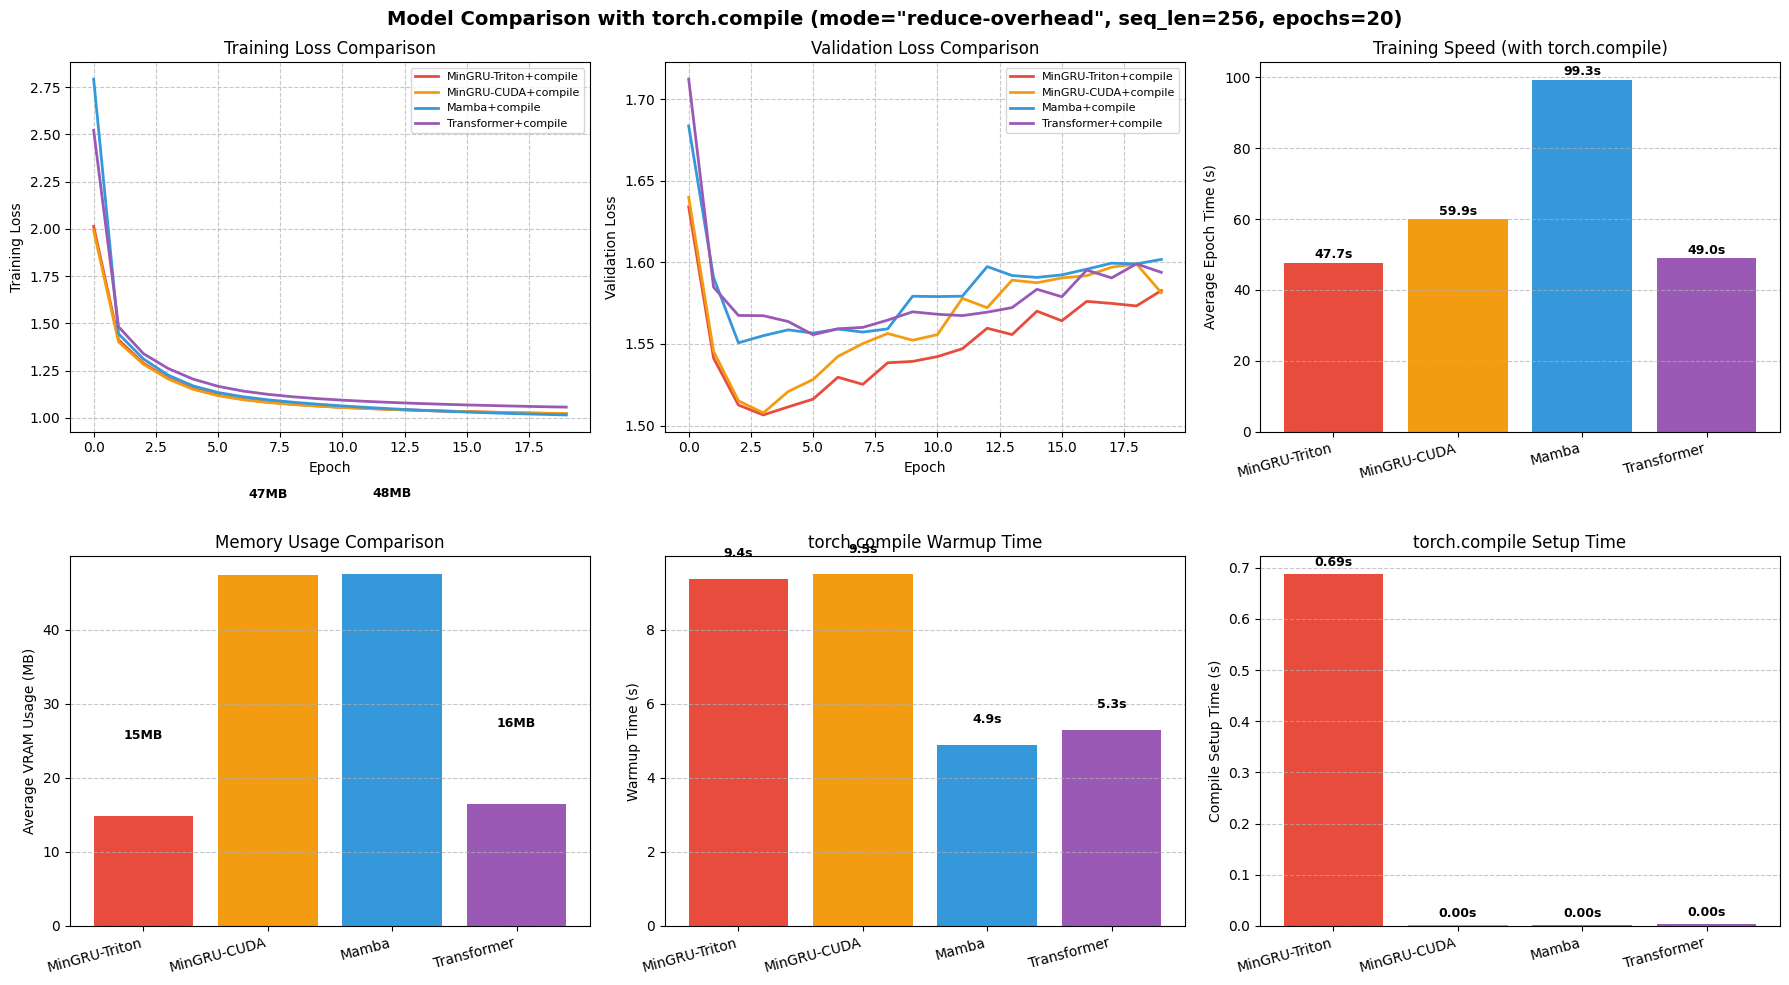

In [15]:
def plot_comparison(results, save_dir):
    """Plot training comparison for compiled models"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    colors = ['#e74c3c', '#f39c12', '#3498db', '#9b59b6']
    
    # Training Loss
    ax = axes[0, 0]
    for (name, history), color in zip(results.items(), colors):
        ax.plot(history['train_loss'], label=name, color=color, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Training Loss')
    ax.set_title('Training Loss Comparison')
    ax.legend(fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Validation Loss
    ax = axes[0, 1]
    for (name, history), color in zip(results.items(), colors):
        ax.plot(history['val_loss'], label=name, color=color, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Validation Loss')
    ax.set_title('Validation Loss Comparison')
    ax.legend(fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Epoch Time
    ax = axes[0, 2]
    names = list(results.keys())
    short_names = [n.replace('+compile', '') for n in names]
    avg_times = [np.mean(h['epoch_time']) for h in results.values()]
    bars = ax.bar(short_names, avg_times, color=colors)
    ax.set_ylabel('Average Epoch Time (s)')
    ax.set_title('Training Speed (with torch.compile)')
    for bar, time_val in zip(bars, avg_times):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{time_val:.1f}s', ha='center', va='bottom', fontweight='bold', fontsize=9)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.setp(ax.get_xticklabels(), rotation=15, ha='right')
    
    # VRAM Usage
    ax = axes[1, 0]
    avg_vram = [np.mean(h['vram_usage']) for h in results.values()]
    bars = ax.bar(short_names, avg_vram, color=colors)
    ax.set_ylabel('Average VRAM Usage (MB)')
    ax.set_title('Memory Usage Comparison')
    for bar, vram in zip(bars, avg_vram):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                f'{vram:.0f}MB', ha='center', va='bottom', fontweight='bold', fontsize=9)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.setp(ax.get_xticklabels(), rotation=15, ha='right')
    
    # Warmup Time
    ax = axes[1, 1]
    warmup_times = [h['warmup_time'] for h in results.values()]
    bars = ax.bar(short_names, warmup_times, color=colors)
    ax.set_ylabel('Warmup Time (s)')
    ax.set_title('torch.compile Warmup Time')
    for bar, wt in zip(bars, warmup_times):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{wt:.1f}s', ha='center', va='bottom', fontweight='bold', fontsize=9)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.setp(ax.get_xticklabels(), rotation=15, ha='right')
    
    # Compile Setup Time
    ax = axes[1, 2]
    compile_ts = [h.get('compile_time', 0) for h in results.values()]
    bars = ax.bar(short_names, compile_ts, color=colors)
    ax.set_ylabel('Compile Setup Time (s)')
    ax.set_title('torch.compile Setup Time')
    for bar, ct in zip(bars, compile_ts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{ct:.2f}s', ha='center', va='bottom', fontweight='bold', fontsize=9)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.setp(ax.get_xticklabels(), rotation=15, ha='right')
    
    plt.suptitle(f'Model Comparison with torch.compile (mode="{COMPILE_MODE}", seq_len={SEQUENCE_LENGTH}, epochs={EPOCHS})',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    save_path = os.path.join(save_dir, 'model_comparison_compiled.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Plot saved to: {save_path}")
    plt.show()


plot_comparison(results, RESULTS_DIR)

In [16]:
# Summary Table
def print_summary(results, models, save_dir):
    print("\n" + "="*100)
    print("SUMMARY (with torch.compile)")
    print("="*100)
    
    data = []
    for name, history in results.items():
        data.append({
            'Model': name,
            'Parameters': f"{count_parameters(models[name]):,}",
            'Final Train Loss': f"{history['train_loss'][-1]:.4f}",
            'Final Val Loss': f"{history['val_loss'][-1]:.4f}",
            'Avg Epoch Time': f"{np.mean(history['epoch_time']):.1f}s",
            'Warmup Time': f"{history['warmup_time']:.1f}s",
            'Avg VRAM': f"{np.mean(history['vram_usage']):.0f}MB",
        })
    
    df = pd.DataFrame(data)
    print(df.to_string(index=False))
    print("="*100)
    
    # Save CSV
    csv_path = os.path.join(save_dir, 'summary.csv')
    df.to_csv(csv_path, index=False)
    print(f"\nSummary saved to: {csv_path}")
    
    # Save detailed results as JSON
    import json
    results_json = {
        name: {k: v if not isinstance(v, list) else v for k, v in hist.items()}
        for name, hist in results.items()
    }
    json_path = os.path.join(save_dir, 'training_history.json')
    with open(json_path, 'w') as f:
        json.dump(results_json, f, indent=2)
    print(f"Training history saved to: {json_path}")
    
    return df

summary_df = print_summary(results, models, RESULTS_DIR)


SUMMARY (with torch.compile)
                Model Parameters Final Train Loss Final Val Loss Avg Epoch Time Warmup Time Avg VRAM
MinGRU-Triton+compile    551,808           1.0222         1.5827          47.7s        9.4s     15MB
  MinGRU-CUDA+compile    551,808           1.0228         1.5814          59.9s        9.5s     47MB
        Mamba+compile    474,880           1.0157         1.6018          99.3s        4.9s     48MB
  Transformer+compile    664,832           1.0571         1.5939          49.0s        5.3s     16MB

Summary saved to: results/11_model_comparison_compiled/summary.csv
Training history saved to: results/11_model_comparison_compiled/training_history.json


## Text Generation Test

In [17]:
def generate_text(model, start_text, max_length=200):
    """Generate text from model"""
    model.eval()
    current_text = start_text
    
    with torch.no_grad():
        for _ in range(max_length):
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output, _ = model(x)
            probs = F.softmax(output[0, -1], dim=0)
            next_idx = torch.multinomial(probs, 1).item()
            current_text += idx_to_char[next_idx]
    
    return current_text


# Generate from each model
start_text = "ROMEO: "
print("\nText Generation Samples (torch.compile):")
print("="*60)

for name, model in models.items():
    generated = generate_text(model, start_text, max_length=150)
    print(f"\n[{name}]")
    print("-"*40)
    print(generated[:200])


Text Generation Samples (torch.compile):


CUDAGraph supports dynamic shapes by recording a new graph for each distinct input size. Recording too many CUDAGraphs may lead to extra overhead. We have observed 51 distinct sizes. Please consider the following options for better performance: a) padding inputs to a few fixed number of shapes; or b) set torch._inductor.config.triton.cudagraph_skip_dynamic_graphs=True. Set torch._inductor.config.triton.cudagraph_dynamic_shape_warn_limit=None to silence this warning.
CUDAGraph supports dynamic shapes by recording a new graph for each distinct input size. Recording too many CUDAGraphs may lead to extra overhead. We have observed 51 distinct sizes. Please consider the following options for better performance: a) padding inputs to a few fixed number of shapes; or b) set torch._inductor.config.triton.cudagraph_skip_dynamic_graphs=True. Set torch._inductor.config.triton.cudagraph_dynamic_shape_warn_limit=None to silence this warning.
CUDAGraph supports dynamic shapes by recording a new graph


[MinGRU-Triton+compile]
----------------------------------------
ROMEO: thou hast not thine eye so

Nurse:
If this do I cannot give me, it is not her access
From day executors. I do not enjoy thee my heart
To hear it, I sa


CUDAGraph supports dynamic shapes by recording a new graph for each distinct input size. Recording too many CUDAGraphs may lead to extra overhead. We have observed 51 distinct sizes. Please consider the following options for better performance: a) padding inputs to a few fixed number of shapes; or b) set torch._inductor.config.triton.cudagraph_skip_dynamic_graphs=True. Set torch._inductor.config.triton.cudagraph_dynamic_shape_warn_limit=None to silence this warning.
CUDAGraph supports dynamic shapes by recording a new graph for each distinct input size. Recording too many CUDAGraphs may lead to extra overhead. We have observed 51 distinct sizes. Please consider the following options for better performance: a) padding inputs to a few fixed number of shapes; or b) set torch._inductor.config.triton.cudagraph_skip_dynamic_graphs=True. Set torch._inductor.config.triton.cudagraph_dynamic_shape_warn_limit=None to silence this warning.
CUDAGraph supports dynamic shapes by recording a new graph


[MinGRU-CUDA+compile]
----------------------------------------
ROMEO: Dweets thou waste both of shrowshiny!
O sign of thee and silver curst more now thou hast sworn.
Show me your bad blessing, no marriage, with the wind;


CUDAGraph supports dynamic shapes by recording a new graph for each distinct input size. Recording too many CUDAGraphs may lead to extra overhead. We have observed 51 distinct sizes. Please consider the following options for better performance: a) padding inputs to a few fixed number of shapes; or b) set torch._inductor.config.triton.cudagraph_skip_dynamic_graphs=True. Set torch._inductor.config.triton.cudagraph_dynamic_shape_warn_limit=None to silence this warning.
CUDAGraph supports dynamic shapes by recording a new graph for each distinct input size. Recording too many CUDAGraphs may lead to extra overhead. We have observed 51 distinct sizes. Please consider the following options for better performance: a) padding inputs to a few fixed number of shapes; or b) set torch._inductor.config.triton.cudagraph_skip_dynamic_graphs=True. Set torch._inductor.config.triton.cudagraph_dynamic_shape_warn_limit=None to silence this warning.
CUDAGraph supports dynamic shapes by recording a new graph


[Mamba+compile]
----------------------------------------
ROMEO: let me have married the county, that
Which our disgrace did bring
The buried Henry of Europe and Sir Rosaline
And with a man says Marcius Francished:



CUDAGraph supports dynamic shapes by recording a new graph for each distinct input size. Recording too many CUDAGraphs may lead to extra overhead. We have observed 51 distinct sizes. Please consider the following options for better performance: a) padding inputs to a few fixed number of shapes; or b) set torch._inductor.config.triton.cudagraph_skip_dynamic_graphs=True. Set torch._inductor.config.triton.cudagraph_dynamic_shape_warn_limit=None to silence this warning.



[Transformer+compile]
----------------------------------------
ROMEO: and what I saw their speech;
And almost proposed between your pleasure.
And you not mean eternal talk of grayard,
The words than it and crown her fath


## Comparison: With vs Without torch.compile

### 결과 분석

torch.compile을 적용했을 때의 주요 차이점:

1. **Warmup 시간**: 첫 번째 forward pass에서 JIT 컴파일이 발생하여 초기 지연
2. **학습 속도**: 컴파일 후 커널 퓨전 및 최적화로 인한 속도 향상
3. **메모리 사용**: 일부 경우 메모리 최적화 효과

### torch.compile 모드별 특징

- `default`: 기본 최적화
- `reduce-overhead`: CUDA graph를 사용하여 커널 실행 오버헤드 감소
- `max-autotune`: 최대 성능을 위한 자동 튜닝 (컴파일 시간 증가)

### 참고사항

- Custom CUDA 커널 (MinGRU CUDA, Mamba, Flash Attention)은 이미 고도로 최적화되어 있어 torch.compile의 효과가 제한적일 수 있음
- Triton 기반 커널과 torch.compile의 조합이 가장 효과적인 경우가 많음